Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
tf.config.list_physical_devices('GPU')

2021-11-28 19:12:57.168845: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 19:12:57.177296: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-11-28 19:12:57.177324: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[]

In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [6]:
# [list(data_dir_train.glob(f'{label}/*.jpg'))[0] for label in class_names]

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [2]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [4]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, 
    image_size=(img_width, img_height),
    shuffle=True, seed=123,
    validation_split = 0.2,
    subset = 'training',
)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


2021-12-01 09:29:13.595043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 09:29:13.684942: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-12-01 09:29:13.684995: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-12-01 09:29:13.718786: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=batch_size, 
    image_size=(img_width, img_height),
    shuffle=True, seed=123,
    validation_split = 0.2,
    subset = 'validation',
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [5]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [6]:
num_classes = len(class_names)
num_classes

9

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

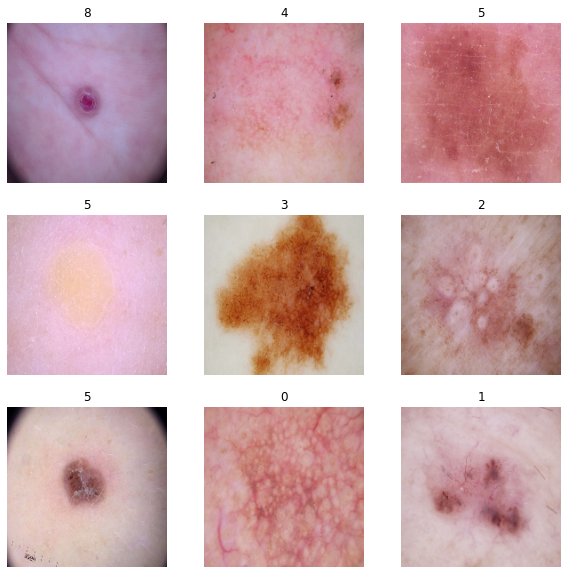

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Input, Rescaling
from tensorflow.keras import layers

In [16]:
### Your code goes here
inputs = keras.Input(shape=(img_width, img_height, 3))

# Center-crop images to 150x150
# x = CenterCrop(height=150, width=150)(inputs)
# Rescale images to [0, 1]
x = layers.Rescaling(scale=1.0 / 255)(inputs)

# Apply some convolution and pooling layers
x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same")(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same")(x)
x = layers.Activation("relu")(x)

# Apply global average pooling to get flat feature vectors
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(32)(x)
x = layers.Dense(16)(x)

# Add a dense classifier on top
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [17]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])

In [18]:
# View the summary of all layers
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0     

### Train the model

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 86s 1s/step - loss: 1.7981 - acc: 0.3488 - val_loss: 2.1927 - val_acc: 0.1499
Epoch 2/20
56/56 [==============================] - 84s 2s/step - loss: 1.5709 - acc: 0.4235 - val_loss: 2.3632 - val_acc: 0.1499
Epoch 3/20
56/56 [==============================] - 85s 2s/step - loss: 1.5173 - acc: 0.4414 - val_loss: 2.5849 - val_acc: 0.1499
Epoch 4/20
56/56 [==============================] - 81s 1s/step - loss: 1.4568 - acc: 0.4671 - val_loss: 2.4348 - val_acc: 0.1499
Epoch 5/20
56/56 [==============================] - 84s 2s/step - loss: 1.4681 - acc: 0.4665 - val_loss: 2.6438 - val_acc: 0.1499
Epoch 6/20
56/56 [==============================] - 88s 2s/step - loss: 1.4236 - acc: 0.4827 - val_loss: 2.2665 - val_acc: 0.1655
Epoch 7/20
56/56 [==============================] - 84s 2s/step - loss: 1.3912 - acc: 0.4883 - val_loss: 2.1495 - val_acc: 0.2148
Epoch 8/20
56/56 [==============================] - 89s 2s/step - loss: 1.3603 - acc: 0.50

### Visualizing training results

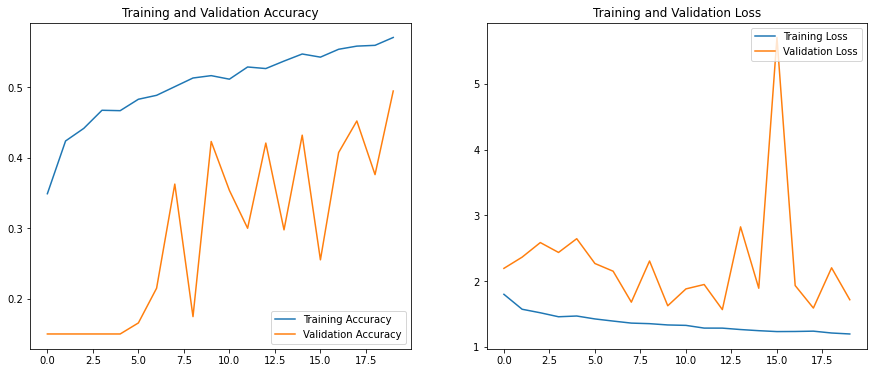

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

The model is underfitting. But the loss is still going down, so maybe more training is needed.

In [7]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = keras.Sequential(
    [
        #layers.CenterCrop(height=120, width=120),
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        layers.RandomRotation((-0.2, 0.2)),
        
    ]
)

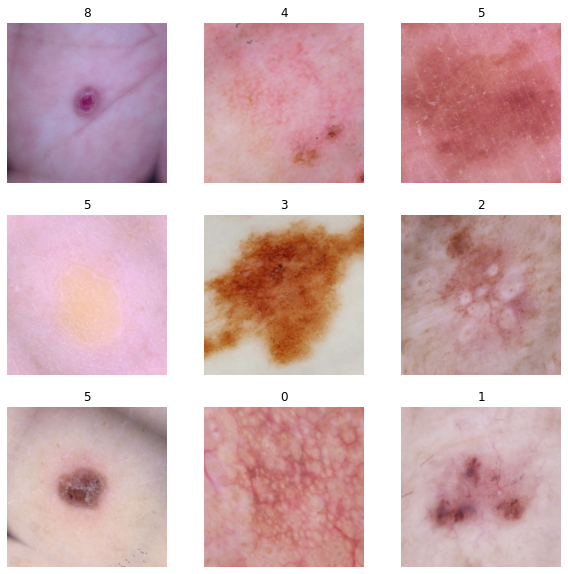

In [8]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        image = images[i].numpy().astype("uint8")
        image = data_augmentation(image)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(int(labels[i]))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [23]:
def make_model(input_shape, num_classes):
    ### Your code goes here
    inputs = layers.Input(shape=(img_width, img_height, 3))

    # Rescale images to [0, 1]
    x = layers.Rescaling(scale=1.0 / 255)(inputs)
    
    # augmentation
    x = data_augmentation(x)

    # Apply some convolution and pooling layers
    x = layers.Conv2D(filters=8, kernel_size=(3, 3), strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=16, kernel_size=(3, 3), strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Apply global average pooling to get flat feature vectors
    #x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1024)(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256)(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    # Add a dense classifier on top
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

### Compiling the model

In [24]:
## Your code goes here
model = make_model(input_shape=(img_width, img_height, 3), 
                   num_classes=num_classes)
model.compile(
    optimizer=keras.optimizers.Adam(2e-4),
    loss="sparse_categorical_crossentropy",
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
)

In [25]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 8)       224       
                                                                 
 batch_normalization_2 (Batc  (None, 180, 180, 8)      32        
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 180, 180, 8)       0         
                                                           

### Training the model

In [26]:
## Your code goes here, note: train your model for 20 epochs
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("model/checkpoints/save_at_{epoch}.h5"),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5)
    #keras.callbacks.EarlyStopping(patience=5)
]

history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
56/56 [==============================] - 22s 385ms/step - loss: 2.1754 - accuracy: 0.2545 - val_loss: 2.1685 - val_accuracy: 0.1499
Epoch 2/50
56/56 [==============================] - 22s 389ms/step - loss: 1.7466 - accuracy: 0.3850 - val_loss: 2.2331 - val_accuracy: 0.1499
Epoch 3/50
56/56 [==============================] - 21s 373ms/step - loss: 1.6219 - accuracy: 0.4308 - val_loss: 2.2548 - val_accuracy: 0.1521
Epoch 4/50
56/56 [==============================] - 20s 353ms/step - loss: 1.5278 - accuracy: 0.4749 - val_loss: 2.2547 - val_accuracy: 0.1544
Epoch 5/50
56/56 [==============================] - 20s 353ms/step - loss: 1.4448 - accuracy: 0.4933 - val_loss: 2.1020 - val_accuracy: 0.2237
Epoch 6/50
56/56 [==============================] - 21s 377ms/step - loss: 1.3851 - accuracy: 0.5073 - val_loss: 2.1867 - val_accuracy: 0.2349
Epoch 7/50
56/56 [==============================] - 20s 351ms/step - loss: 1.3593 - accuracy: 0.5329 - val_loss: 1.7172 - val_accuracy: 0.3803

### Visualizing the results

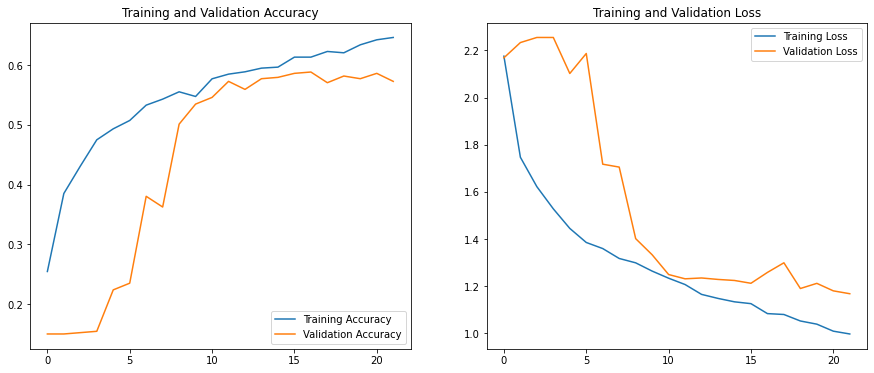

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
After augmenting the model, the scores improved.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
## Your code goes here.
from collections import Counter
train_labels = []
for file in list(data_dir_train.glob('*/*.jpg')):
    label = str(file).split('/')[2]
    train_labels.append(label)
Counter(train_labels)

Counter({'seborrheic keratosis': 77,
         'vascular lesion': 139,
         'actinic keratosis': 114,
         'melanoma': 438,
         'dermatofibroma': 95,
         'nevus': 357,
         'pigmented benign keratosis': 462,
         'squamous cell carcinoma': 181,
         'basal cell carcinoma': 376})

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis, melanoma, nevus and basal cell carcinoma

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
# !pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [31]:
data_dir_train_augmented=pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train_Augmented/")
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train_augmented) + '/' +  i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train_Augmented/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD76C2B1970>: 100%


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train_Augmented/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train_Augmented/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD76C358C10>: 100%


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train_Augmented/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD76C306F40>: 100


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train_Augmented/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD76C28DC70>: 100%


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train_Augmented/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD76C2B1AF0>: 100%


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train_Augmented/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train_Augmented/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD76C3A5CA0>: 100%


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train_Augmented/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD76C3E6100>: 100%


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
image_count_train = len(list(data_dir_train_augmented.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
from glob import glob

In [34]:
path_list_new = [x for x in glob(os.path.join(data_dir_train_augmented, '*','output', '*.jpg'))]
path_list_new[:3]

['Skin cancer ISIC The International Skin Imaging Collaboration/Train_Augmented/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011166.jpg_215b1f9c-3874-4528-9f44-6ceeb987c42b.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train_Augmented/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011139.jpg_40ec91e4-c90d-4975-8f80-cabc1bd1b71e.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train_Augmented/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010942.jpg_6e5536e2-47ce-4c0a-8ecd-6a721edf4e49.jpg']

In [35]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train_augmented, '*','output', '*.jpg'))]
lesion_list_new[:3]

['seborrheic keratosis', 'seborrheic keratosis', 'seborrheic keratosis']

In [36]:
# dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [37]:
# df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)

In [38]:
# new_df['Label'].value_counts()

In [39]:
# original distribution
Counter(train_labels)

Counter({'seborrheic keratosis': 77,
         'vascular lesion': 139,
         'actinic keratosis': 114,
         'melanoma': 438,
         'dermatofibroma': 95,
         'nevus': 357,
         'pigmented benign keratosis': 462,
         'squamous cell carcinoma': 181,
         'basal cell carcinoma': 376})

In [40]:
# balanced distribution
train_labels_augmented = train_labels + lesion_list_new
Counter(train_labels_augmented)

Counter({'seborrheic keratosis': 577,
         'vascular lesion': 639,
         'actinic keratosis': 614,
         'melanoma': 938,
         'dermatofibroma': 595,
         'nevus': 857,
         'pigmented benign keratosis': 962,
         'squamous cell carcinoma': 681,
         'basal cell carcinoma': 876})

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [41]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [42]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_augmented,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [43]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_augmented,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [44]:
## your code goes here
model = make_model(input_shape=(img_width, img_height, 3), num_classes=num_classes)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [45]:
## your code goes here
model.compile(
    optimizer=keras.optimizers.Adam(2e-4),
    loss="sparse_categorical_crossentropy",
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
)

#### **Todo:**  Train your model

In [46]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("model/checkpoints/save_at_{epoch}.h5"),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5)
    #keras.callbacks.EarlyStopping(patience=5)
]

history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
169/169 [==============================] - 68s 399ms/step - loss: 2.0285 - accuracy: 0.2556 - val_loss: 2.1915 - val_accuracy: 0.1663
Epoch 2/50
169/169 [==============================] - 69s 409ms/step - loss: 1.6074 - accuracy: 0.3874 - val_loss: 1.9438 - val_accuracy: 0.2591
Epoch 3/50
169/169 [==============================] - 63s 373ms/step - loss: 1.4826 - accuracy: 0.4343 - val_loss: 1.4941 - val_accuracy: 0.4254
Epoch 4/50
169/169 [==============================] - 64s 375ms/step - loss: 1.3886 - accuracy: 0.4727 - val_loss: 1.2506 - val_accuracy: 0.5382
Epoch 5/50
169/169 [==============================] - 67s 396ms/step - loss: 1.3284 - accuracy: 0.4918 - val_loss: 1.2920 - val_accuracy: 0.5137
Epoch 6/50
169/169 [==============================] - 63s 369ms/step - loss: 1.2553 - accuracy: 0.5250 - val_loss: 1.1454 - val_accuracy: 0.5583
Epoch 7/50
169/169 [==============================] - 68s 399ms/step - loss: 1.2088 - accuracy: 0.5473 - val_loss: 1.1531 - val_ac

#### **Todo:**  Visualize the model results

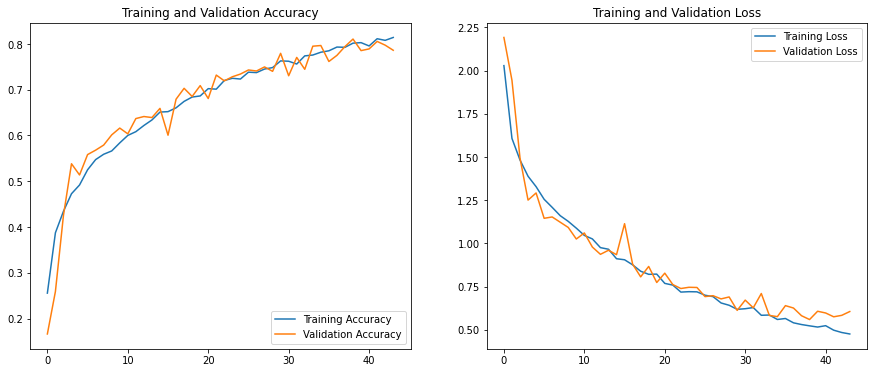

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Balancing the labels helped with underfitting and improved the scores.